In [1]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

# Data distribution

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


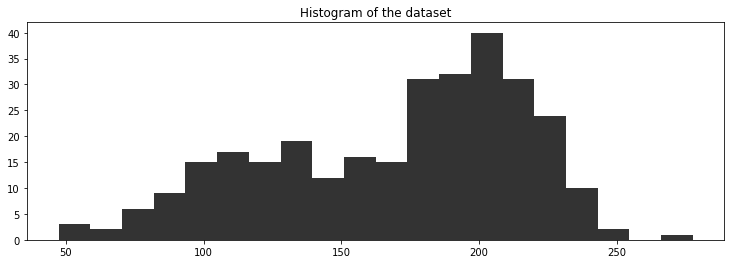

In [2]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

It appears the data has a bimodal form, which indicates that there may are two clusters within this dataset.

We do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on $(0, 1)$. We call call this $p_1$, so the probability of belonging to cluster 2 is therefore $p_2 = 1 - p_1$.

In [11]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[0 0 0 0 0 0 1 0 0 0]


In [12]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value)
print("Assigned center: ", center_i.tag.test_value)
print("Assigned standard deviation: ", sd_i.tag.test_value)

Random assignments:  [0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1
 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1
 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0
 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1
 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1
 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1
 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0
 0 1 1 1]
Assigned center:  [120. 120. 120. 120. 120. 120. 190. 120. 120. 120. 190. 190. 120. 120.
 120. 190. 190. 120. 120. 120. 120. 120. 190. 120. 190. 120. 120. 190.
 120. 190. 120. 190. 190. 120. 190. 190. 190. 120. 120. 190. 190. 190.
 190. 190. 120. 190. 120. 120. 190. 190. 120. 120. 120. 120. 120. 190.
 120. 190. 190. 120. 190. 190. 190. 190. 120. 190. 120. 120. 190. 1

In [26]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(75000, step=[step1, step2])

/Users/cynthiayang/workspace/bayesian_methods/bayesian-venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]


Sampling 2 chains for 1_000 tune and 75_000 draw iterations (2_000 + 150_000 draws total) took 1059 seconds.
The number of effective samples is smaller than 10% for some parameters.


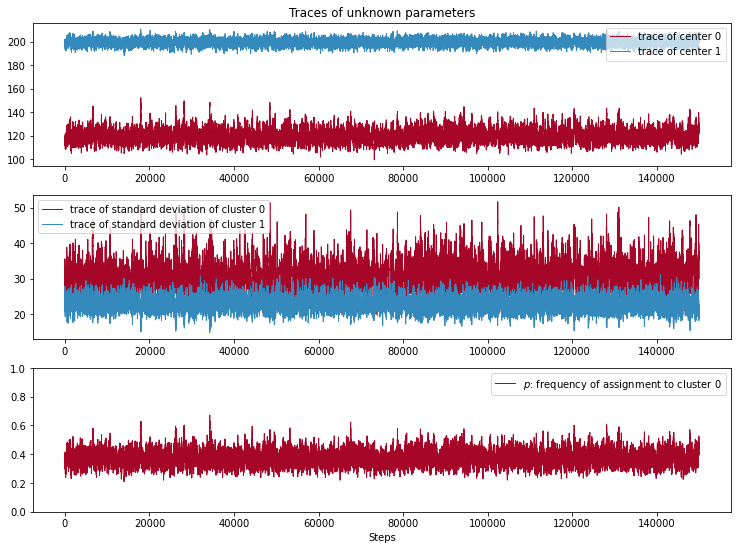

In [27]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend()

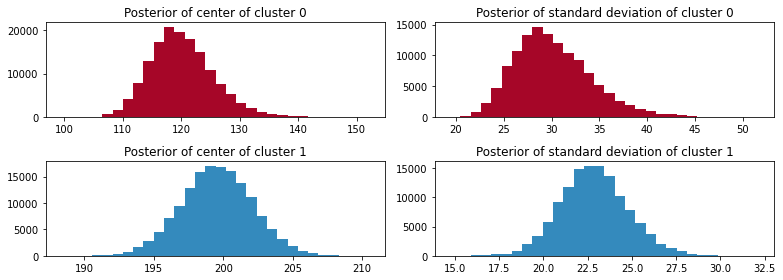

In [28]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

# Visualization

Text(0.5, 1.0, 'Visualizing Clusters using posterior-mean parameters')

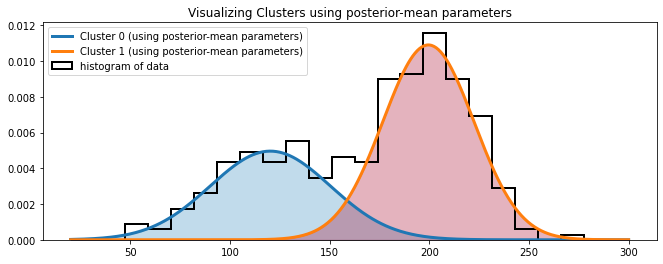

In [31]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",\
         lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],\
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],\
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters")

# Prediction

In [49]:
p_trace = trace["p"]
std_trace = trace["sds"]

for x_i in range(120,200):
    v = p_trace * norm.pdf(x_i, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm.pdf(x_i, loc=center_trace[:, 1], scale=std_trace[:, 1])
    print("Value:", x_i)
    print("Probability of belonging to cluster 1:", v.mean())

Value: 120
Probability of belonging to cluster 1: 1.0
Value: 121
Probability of belonging to cluster 1: 1.0
Value: 122
Probability of belonging to cluster 1: 1.0
Value: 123
Probability of belonging to cluster 1: 1.0
Value: 124
Probability of belonging to cluster 1: 1.0
Value: 125
Probability of belonging to cluster 1: 1.0
Value: 126
Probability of belonging to cluster 1: 1.0
Value: 127
Probability of belonging to cluster 1: 1.0
Value: 128
Probability of belonging to cluster 1: 1.0
Value: 129
Probability of belonging to cluster 1: 1.0
Value: 130
Probability of belonging to cluster 1: 1.0
Value: 131
Probability of belonging to cluster 1: 1.0
Value: 132
Probability of belonging to cluster 1: 1.0
Value: 133
Probability of belonging to cluster 1: 1.0
Value: 134
Probability of belonging to cluster 1: 1.0
Value: 135
Probability of belonging to cluster 1: 0.9999533333333334
Value: 136
Probability of belonging to cluster 1: 0.9999
Value: 137
Probability of belonging to cluster 1: 0.99986
Value: